
<div style="line-height:2px;border: solid orange">
    <p>
    <p style="color:blue;font-family:arial;text-align:right;font-size:20"> Visión por Computador &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Master en Ciencias de Datos e Ingeniería de Ordenadores   &nbsp;&nbsp;
  <p style="color:blue;font-family:arial;text-align:right;font-size:16"> Rosa Mª. Rodríguez Sánchez   &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> Dpto. Ciencias de la Computación e Inteligencia Artificial. &nbsp;&nbsp;
    <p style="color:blue;font-family:arial;text-align:right;font-size:10"> ETSIIT. Universidad de Granada   &nbsp;&nbsp;
        <p>
</div>

# Trabajo 3- Segmentación de peatones

## Autores:
    -  Juan Emilio Martínez Manjón
    -  Antonio David Villegas Yeguas

Vamos a comenzar cargando los módulos que utilizaremos y leyendo las imágenes para segmentación:

In [1]:
import math
import cv2
import os
import pandas as pd
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Model, Sequential
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping
from keras.layers import Softmax, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, ReLU, Dense, Normalization, Dropout, Lambda, BatchNormalization, RandomFlip, RandomRotation
import random
from time import time
random.seed(1234)

In [2]:
# Establecemos una semilla
random.seed(1234)

# Creamos una función que lea todas las imágenes de un directorio
# concreto.
def load_images(directorio, color=0):
    x_imagenes = []
    y_imagenes = []
    for filename in os.listdir("{}/images".format(directorio)):
        filename_mask = filename[:-4]
        filename_mask = "{}_mask.png".format(filename_mask)

        nombre_x = "{}/images/{}".format(directorio, filename)
        nombre_mascara = "{}/mask/{}".format(directorio, filename_mask)
        img = cv2.imread(nombre_x,color)
        mascara = cv2.imread(nombre_mascara,0)
        if img is not None:
            x_imagenes.append(img)
            y_imagenes.append(mascara)
    return x_imagenes, y_imagenes

In [3]:

# Leemos las imágenes de entrenamiento
X_train, y_train = load_images("data/segmentation/train",1)
# Leemos las imágenes de test
X_test, y_test = load_images("data/segmentation/test",1)


Debido a que tienen distintos tamaños, vamos a reescalar todas las imágenes al mismo tamaño:

In [4]:
def reescalar(conjunto_imagenes, nuevo_tam):
    imagenes_reescaladas = []
    
    for img in conjunto_imagenes:
        imagenes_reescaladas.append(cv2.resize(img, nuevo_tam))
    
    return np.array(imagenes_reescaladas)

Aplicamos el reescalado, y dividimos el conjunto en entrenamiento, validación y test.

In [5]:
NUEVO_TAM = (214, 214)

# reescalamos las imagenes al nuevo tamaño
X_train_val_reescalado = reescalar(X_train, NUEVO_TAM)
y_train_val_inicial = reescalar(y_train, NUEVO_TAM)
X_test_reescalado = reescalar(X_test, NUEVO_TAM)
y_test_inicial = reescalar(y_test, NUEVO_TAM)

X_train_val = []
X_test = []

# pasamos el rango de 0-255 con uint8 a 0-1 con float
for imagen in X_train_val_reescalado:
    X_train_val.append(imagen / 255)
    
for imagen in X_test_reescalado:
    X_test.append(imagen / 255)

X_train_val = np.array(X_train_val)
X_test = np.array(X_test)


print(X_train_val[0].dtype)

float64


Vamos a mostrar una imagen, para ver como son las imágenes y la salida que queremos.

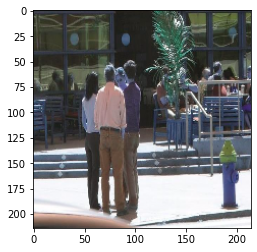

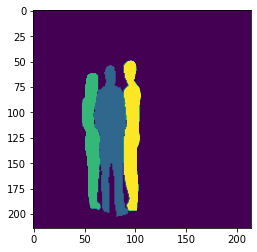

In [6]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()


# vemos que las imagenes de test tienen valores 0 para el fondo, 1 para la primera persona, 2 para la segunda, etc
plt.figure()
plt.imshow(y_train_val_inicial[0])
plt.show()

Como vemos con las etiquetas de las imágenes, se tratan de imágenes con N + 1 valores, siendo N el número de peatones que aparece en la imagen. El 0 siempre es el fondo, mientras que a cada peaton se le asigna un número.

En nuestro caso solo queremos distinguir entre fondo y peatón, así que modificaremos las imágenes para dejar a 1 cualquier valor distinto a 0.

In [7]:
y_train_val = []
y_test = []

# convertimos las máscaras a imágenes de 0 o 1, 0 fondo 1 persona
for imagen in y_train_val_inicial:
    resultado = np.where(imagen == 0, 0, 1).astype(np.float64)
    resultado_negado = np.where(imagen == 0, 1, 0).astype(np.float64)
    y_train_val.append(cv2.merge((resultado, resultado_negado)))
                       

for imagen in y_test_inicial:
    resultado = np.where(imagen == 0, 0, 1).astype(np.float64)
    resultado_negado = np.where(imagen == 0, 1, 0).astype(np.float64)

    y_test.append(cv2.merge((resultado, resultado_negado)))
    
y_train_val = np.array(y_train_val)
y_test = np.array(y_test)

print(y_test.shape)

(74, 214, 214, 2)


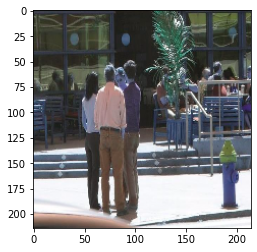

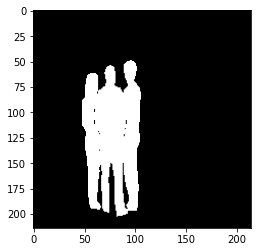

In [8]:
plt.figure()
plt.imshow(X_train_val[0])
plt.show()

# ya si aparecen como imágenes en blanco/negro
plt.figure()
plt.imshow(y_train_val[0, :, :, 0], "gray")
plt.show()

Una vez aplicada esta transformación a todas las imágenes, podemos preparar los conjuntos de TensorFlow:

In [9]:
# separamos train en train/validacion y convertimos todos a dataset de tensorflow
ntrain = round(0.8*len(y_train_val))
nval = len(X_train_val)-ntrain

idx = np.random.permutation(np.arange(len(y_train_val)))
X_train = X_train_val[idx[0:ntrain],:]
y_train = y_train_val[idx[0:ntrain]]
X_val = X_train_val[idx[ntrain+1:len(y_train_val)],:]
y_val = y_train_val[idx[ntrain+1:len(y_train_val)]]


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



2022-06-20 10:34:04.957622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 10:34:04.958960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


A continuación hemos preparado algunas funciones auxiliares de cara a realizar el ejercicio. La primera de ellas se trata del cálculo de la medida MeanIoU, para saber como de buena es la segmentación, la segunda es una función para mostrar la evolución de una red neuronal a lo largo de su entrenamiento, y la tercera una función genérica para entrenar y evaluar un modelo dados los distintos conjuntos, el modelo, y la función de pérdida a usar.

In [10]:
def mean_iou(y_true, y_pred, smooth=1):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

## Función que muestra la evolución de las accuracy de train y validación
## durante el entrenamiento.
def mostrar_evolucion(hist):

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    
def evaluar_modelo(nombre, modelo, train, val, test, f_loss = BinaryCrossentropy(from_logits = False)):
    
    modelo.compile(
        optimizer = "adam", 
        loss = f_loss
    )

    # Entrenamos el modelo usando callbacks para parar de entrenar
    # si la validación se aleja demasiado del entrenamiento
    callback = EarlyStopping(patience=3,restore_best_weights=True)
    start = time()
    history = modelo.fit(train,
                    epochs = 100,
                    validation_data = val,
                    callbacks = callback)
    first_training_time = time()-start
    mostrar_evolucion(history)

    predicciones = modelo.predict(test)

    predicciones = np.where(predicciones < 0.5, 0.0, 1.0)

    mean_iou_modelo = mean_iou(predicciones, y_test)
    print(mean_iou_modelo)

    acc_modelo = tf.keras.metrics.Accuracy()
    acc_modelo.reset_state()
    acc_modelo.update_state(predicciones, y_test)


    fila = pd.Series(data={'tiempo_entrenamiento':first_training_time, 
                          'mean_iou':mean_iou_modelo, 
                          'accuracy':acc_modelo.result().numpy(),
                          "tam_dim_latente": modelo.layers[len(modelo.layers)//2 + 2].output_shape}, name=nombre)

    fila_df = pd.DataFrame([fila], index = [nombre])
    return fila_df, modelo, predicciones



Con las funciones creadas, pasamos a evaluar distintos modelos, comenzando por el modelo base que aparece en el guión, además, se probará tanto con la tasa de accierto como con MSE de función de pérdida. Al final de la evaluación de todos los modelos se comentarán los resultados y se realizarán comparaciones:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 214, 214, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 214, 214, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      36928     
                                                                 
 re_lu_1 (ReLU)              (None, 107, 107, 64)      0

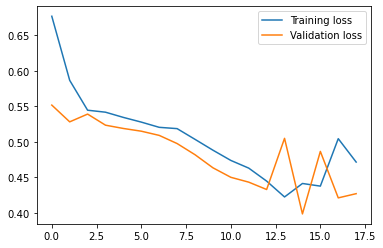

3/3 [==============================] - 1s 272ms/step
0.7539322266357861
Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 0.2350 - val_loss: 0.1721
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 0.1848 - val_loss: 0.1878
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.1855 - val_loss: 0.1737
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 0.1783 - val_loss: 0.1671
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.1716 - val_loss: 0.1689
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 0.1709 - val_loss: 0.1638
Epoch 7/100
3/3 [==============================] - 5s 2s/step - loss: 0.1666 - val_loss: 0.1599
Epoch 8/100
3/3 [==============================] - 5s 2s/step - loss: 0.1631 - val_loss: 0.1558
Epoch 9/100
3/3 [==============================] - 5s 2s/step - loss: 0.1597 - val_loss: 0.1511
Epoch 10/100
3/3 [==============================] - 5s 2s/step -

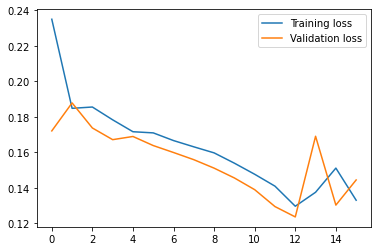

3/3 [==============================] - 1s 316ms/step
0.7638557552954256


In [11]:
resultados = pd.DataFrame(columns = ["tiempo_entrenamiento", "mean_iou", "accuracy", "tam_dim_latente"])



modelo_base = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base.summary()

weights = modelo_base.get_weights()

fila_resultados, _, _ = evaluar_modelo("modelo_base", modelo_base, train_dataset, validation_dataset, test_dataset)
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)

modelo_base.set_weights(weights)

fila_resultados, _, _ = evaluar_modelo("modelo_base_mse", modelo_base, train_dataset, validation_dataset, test_dataset, f_loss = "mse")
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)



Una de las modificaciones que proponemos es hacer un modelo más profundo, con más capas de convolución, pooling y convolución traspuesta, de cara a tener un modelo con un espacio latente más pequeño todavía:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 214, 214, 3)      7         
 ion)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 214, 214, 64)      1792      
                                                                 
 re_lu_3 (ReLU)              (None, 214, 214, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 107, 107, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 64)      36928     
                                                                 
 re_lu_4 (ReLU)              (None, 107, 107, 64)     

3/3 [==============================] - 5s 2s/step - loss: 0.2308 - val_loss: 0.2556
Epoch 47/100
3/3 [==============================] - 5s 2s/step - loss: 0.2199 - val_loss: 0.2544
Epoch 48/100
3/3 [==============================] - 5s 2s/step - loss: 0.2113 - val_loss: 0.2475
Epoch 49/100
3/3 [==============================] - 5s 2s/step - loss: 0.2057 - val_loss: 0.2458
Epoch 50/100
3/3 [==============================] - 5s 2s/step - loss: 0.1990 - val_loss: 0.2500
Epoch 51/100
3/3 [==============================] - 5s 2s/step - loss: 0.1939 - val_loss: 0.2505
Epoch 52/100
3/3 [==============================] - 5s 2s/step - loss: 0.1886 - val_loss: 0.2463


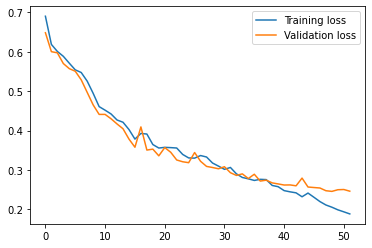

3/3 [==============================] - 1s 279ms/step
0.8415709604996564
Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 0.2468 - val_loss: 0.2126
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 0.2105 - val_loss: 0.1939
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.1948 - val_loss: 0.1922
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 0.1887 - val_loss: 0.1866
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.1850 - val_loss: 0.1756
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 0.1753 - val_loss: 0.1672
Epoch 7/100
3/3 [==============================] - 5s 2s/step - loss: 0.1668 - val_loss: 0.1570
Epoch 8/100
3/3 [==============================] - 5s 2s/step - loss: 0.1554 - val_loss: 0.1475
Epoch 9/100
3/3 [==============================] - 5s 2s/step - loss: 0.1492 - val_loss: 0.1426
Epoch 10/100
3/3 [==============================] - 5s 2s/step -

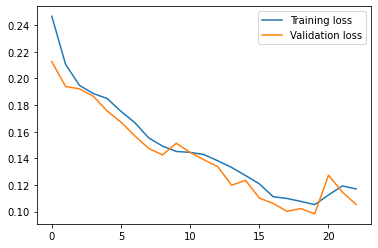

3/3 [==============================] - 1s 292ms/step
0.8049015997185787


In [12]:

modelo_base_deep = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base_deep.summary()



weights = modelo_base_deep.get_weights()

fila_resultados, _, _ = evaluar_modelo("modelo_deep", modelo_base_deep, train_dataset, validation_dataset, test_dataset)
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)

modelo_base_deep.set_weights(weights)

fila_resultados, _, _ = evaluar_modelo("modelo_deep_mse", modelo_base_deep, train_dataset, validation_dataset, test_dataset, f_loss = "mse")
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)




La siguiete propuesta se trata en cambiar el tipo de pooling utilizado, para usar la media en lugar del máximo de la ventana:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 214, 214, 3)      7         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 214, 214, 64)      1792      
                                                                 
 re_lu_8 (ReLU)              (None, 214, 214, 64)      0         
                                                                 
 average_pooling2d (AverageP  (None, 107, 107, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_13 (Conv2D)          (None, 107, 107, 64)      36928     
                                                                 
 re_lu_9 (ReLU)              (None, 107, 107, 64)     

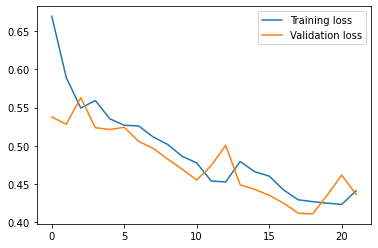

3/3 [==============================] - 1s 264ms/step
0.7699750660952168
Epoch 1/100
3/3 [==============================] - 5s 1s/step - loss: 0.2642 - val_loss: 0.1653
Epoch 2/100
3/3 [==============================] - 5s 1s/step - loss: 0.1548 - val_loss: 0.1589
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 0.1593 - val_loss: 0.1532
Epoch 4/100
3/3 [==============================] - 5s 1s/step - loss: 0.1561 - val_loss: 0.1527
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.1549 - val_loss: 0.1518
Epoch 6/100
3/3 [==============================] - 5s 1s/step - loss: 0.1530 - val_loss: 0.1496
Epoch 7/100
3/3 [==============================] - 5s 1s/step - loss: 0.1508 - val_loss: 0.1454
Epoch 8/100
3/3 [==============================] - 5s 2s/step - loss: 0.1467 - val_loss: 0.1401
Epoch 9/100
3/3 [==============================] - 5s 2s/step - loss: 0.1398 - val_loss: 0.1315
Epoch 10/100
3/3 [==============================] - 5s 2s/step -

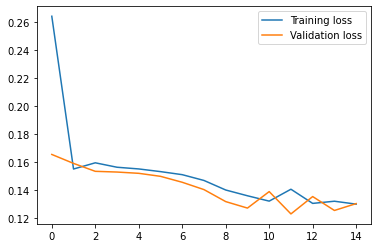

3/3 [==============================] - 1s 284ms/step
0.7604714394508462


In [13]:

modelo_base_avg = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(64, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(64, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_base_avg.summary()


weights = modelo_base.get_weights()

fila_resultados, _, _ = evaluar_modelo("modelo_avg", modelo_base_avg, train_dataset, validation_dataset, test_dataset)
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)

modelo_base_avg.set_weights(weights)

fila_resultados, _, _ = evaluar_modelo("modelo_avg_mse", modelo_base_avg, train_dataset, validation_dataset, test_dataset, f_loss = "mse")
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)




La última propuesta se trata de un modelo que utiliza menos filtros en las convoluciones, de cara a hacer una red más simple y comprobar si sigue funcionando:

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 214, 214, 3)      7         
 ion)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 214, 214, 32)      896       
                                                                 
 re_lu_11 (ReLU)             (None, 214, 214, 32)      0         
                                                                 
 average_pooling2d_2 (Averag  (None, 107, 107, 32)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_18 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 re_lu_12 (ReLU)             (None, 107, 107, 32)     

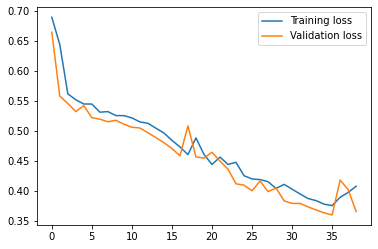

3/3 [==============================] - 0s 103ms/step
0.7721668320875347
Epoch 1/100
3/3 [==============================] - 2s 647ms/step - loss: 0.2465 - val_loss: 0.2230
Epoch 2/100
3/3 [==============================] - 2s 584ms/step - loss: 0.2074 - val_loss: 0.1711
Epoch 3/100
3/3 [==============================] - 2s 627ms/step - loss: 0.1823 - val_loss: 0.1879
Epoch 4/100
3/3 [==============================] - 2s 593ms/step - loss: 0.1911 - val_loss: 0.1812
Epoch 5/100
3/3 [==============================] - 2s 633ms/step - loss: 0.1813 - val_loss: 0.1678
Epoch 6/100
3/3 [==============================] - 2s 601ms/step - loss: 0.1738 - val_loss: 0.1748
Epoch 7/100
3/3 [==============================] - 2s 578ms/step - loss: 0.1752 - val_loss: 0.1666
Epoch 8/100
3/3 [==============================] - 2s 638ms/step - loss: 0.1704 - val_loss: 0.1680
Epoch 9/100
3/3 [==============================] - 2s 574ms/step - loss: 0.1717 - val_loss: 0.1655
Epoch 10/100
3/3 [===================

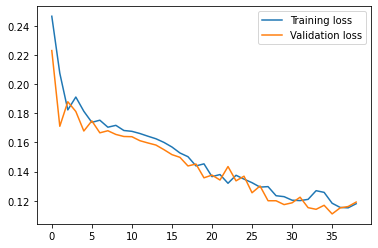

3/3 [==============================] - 0s 114ms/step
0.7855769370090875


In [14]:

modelo_menos_filtros = Sequential([
    Normalization(input_shape = (NUEVO_TAM[0], NUEVO_TAM[1], 3)),
    Conv2D(32, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(32, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"),
    Conv2D(32, 3, strides = (1, 1), padding = "same"),
    ReLU(),
    Conv2D(32, 3, strides = (1, 1), padding = "same"),
    # pasamos a decodificar
    Conv2DTranspose(32, 4,  strides = (2, 2), padding = "same"),
    Conv2DTranspose(32, 4,  strides = (2, 2), padding = "valid"),
    Conv2D(2, 1, strides = (1, 1), padding = "valid", activation = "softmax")
])

modelo_menos_filtros.summary()



weights = modelo_menos_filtros.get_weights()

fila_resultados, _, _ = evaluar_modelo("modelo_menos_filtros", modelo_menos_filtros, train_dataset, validation_dataset, test_dataset)
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)

modelo_menos_filtros.set_weights(weights)

fila_resultados, _, _ = evaluar_modelo("modelo_menos_filtros_mse", modelo_menos_filtros, train_dataset, validation_dataset, test_dataset, f_loss = "mse")
resultados = pd.concat([fila_resultados, resultados], ignore_index=False)



Una vez acabadas todas las ejecuciones, estos son los resultados:

In [15]:
resultados


,tiempo_entrenamiento,mean_iou,accuracy,tam_dim_latente
modelo_menos_filtros_mse,75.909896,0.785577,0.879914,"(None, 53, 53, 32)"
modelo_menos_filtros,75.053646,0.772167,0.871438,"(None, 53, 53, 32)"
modelo_avg_mse,72.530583,0.760471,0.863941,"(None, 53, 53, 64)"
modelo_avg,107.600935,0.769975,0.870041,"(None, 53, 53, 64)"
modelo_deep_mse,119.898103,0.804902,0.891906,"(None, 13, 13, 64)"
modelo_deep,270.492205,0.841571,0.913971,"(None, 13, 13, 64)"
modelo_base_mse,80.28258,0.763856,0.86612,"(None, 53, 53, 64)"
modelo_base,91.742744,0.753932,0.859705,"(None, 53, 53, 64)"


<AxesSubplot:title={'center':'Comparación de MeanIoU en el conjunto de test'}>

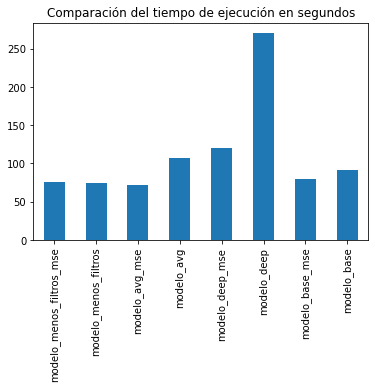

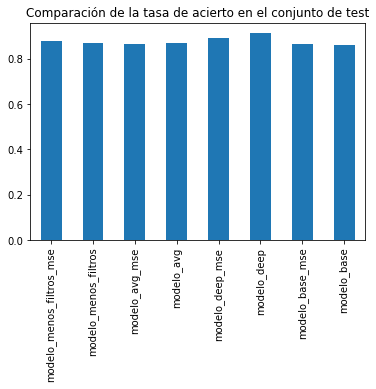

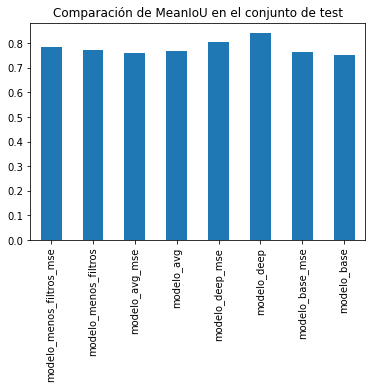

In [16]:
resultados.plot(y = "tiempo_entrenamiento", kind = "bar", title = "Comparación del tiempo de ejecución en segundos", legend = False)
resultados.plot(y = "accuracy", kind = "bar", title = "Comparación de la tasa de acierto en el conjunto de test", legend = False)
resultados.plot(y = "mean_iou", kind = "bar", title = "Comparación de MeanIoU en el conjunto de test", legend = False)

Lo primero que podemos observar rápidamente es como utilizar un modelo más profundo, con un tamaño de dimensión latente más pequeño ha funcionado bastante bien, y ha obtenido unos resultados bastante mejores que el resto.

Por otro lado, vemos que el uso de MSE como función de perdida hay casos en los que funciona mejor (el modelo base y el modelo con menos filtros), y otros en los que funciona peor (modelo profundo y modelo con avg. pooling), por lo que habría que hacer un estudio más en profundidad para ver si realmente es relevante que función de perdida escoger para este problema.

Finalmente, como era de esperar, el modelo con más capas, y el que mejor resultado nos ha dado, también es el que mayor tiempo de entrenamiento ha necesitado.